In [1]:
import requests
from bs4 import BeautifulSoup as BSoup
import pandas as pd

## Setting up for testing
Use sqlite3 to connect to the edgar_idx database

In [2]:
import sqlite3
conn3 = sqlite3.connect('edgar_idx.db')
cursor=conn3.cursor()

Set the ticker and pull out the list of 10-Q's and 10-K's for it from the database. Save each to a CSV file.

In [3]:
ticker = "IT"

## If necessary, update the idx and cik_ticker_name tables in the database

In [4]:
from MyEdgarDb import get_list_sec_filings, get_cik_ticker_lookup_db, lookup_cik_ticker
print("Updating master index.")
get_list_sec_filings ()
print("Updating CIK-ticker lookup table.")
get_cik_ticker_lookup_db ()

Updating master index.
Updating CIK-ticker lookup table.


In [ ]:
#cursor.execute('''SELECT * FROM idx WHERE Symbol=?;''', ("ABBV",))
cursor.execute('''SELECT * FROM cik_ticker_name WHERE ticker=?;''',(ticker,))
res=cursor.fetchall()
print(res)
cursor.execute('''SELECT * FROM idx WHERE cik=?;''', (res[0][0],))
recs = cursor.fetchall()
names = list(map(lambda x: x[0], cursor.description))
print(names)
df = pd.DataFrame(data=recs, columns=names)
df['date'] = pd.to_datetime(df['date'])
df.columns
df.size
df.dtypes
#print(type(recs))
print(recs)
#conn3.close()
df[df.type == "10-Q"].to_csv("TestData\\"+ticker.lower()+"_all_10qs.csv", index=None)
df[df.type == "10-K"].to_csv("TestData\\"+ticker.lower()+"_all_10ks.csv", index=None)
#df[df.type == "20-F"].to_csv("TestData\\"+ticker.lower()+"_all_20fs.csv", index=None)

The thus created CSV files can be read back in

In [ ]:
all_10Ks =pd.read_csv("TestData\\{:s}_all_10ks.csv".format(ticker.lower()), parse_dates=['date'], dtype={'cik':str, 'conm':str, 'type':str,'path':str})
all_10Qs =pd.read_csv("TestData\\{:s}_all_10qs.csv".format(ticker.lower()), parse_dates=['date'], dtype={'cik':str, 'conm':str, 'type':str,'path':str})

## Verifying Canslim is correctly loaded/populated
First, create the Canslim object, which should load all SecFilings* 

In [ ]:
from CanslimParams import CanslimParams
canslim = CanslimParams(ticker, all_10Qs, all_10Ks)
canslim.loadData()

Print some diagnostics

In [ ]:
print(canslim.n10Ks)
print(canslim.n10Qs)
print(canslim.errorLog)

Print EPS's for all quarters and years

In [ ]:
for i in range(0, canslim.n10Qs):
    print(canslim.getEpsQuarter(i))

In [ ]:
for i in range(0, canslim.n10Ks):
    print(canslim.getEpsAnnual(i))

After the SecFilings have actually been accessed (through getting the EPS values), the quartersList and yearsList should be populated now.

In [ ]:
print(canslim.quartersList)
print(canslim.yearsList)

## Verifying that a 10Q filing is loaded correctly
First, set the correct path to the filing to load (be sure to update the last two arguments, if necessary).
Then, load the SecFiling.

In [ ]:
ticker = "OSK"  ## Note that this will overwrite the `ticker` set above

In [ ]:
from os import path, getenv
#file_path = path.join("C:", "Users", "Carola", "jupyternbs", "SECDATA", "OSHKOSH CORP", "775158_OSHKOSH CORP_10-Q_2019-08-000000")
file_path = "C:\\Users\\Carola\\jupyternbs\\SECDATA\\OSHKOSH CORP\\775158_OSHKOSH CORP_10-Q_2019-08-000000"

In [ ]:
from SecFiling10Q import SecFiling10Q
filing = SecFiling10Q(ticker)
filing.load(file_path)

Now we can print some things that should be loaded from the filing.

In [ ]:
print(filing.getReportDate())
print("Eps=", filing.getEps())

Print some diagnostics (all_tags contains the section from the filing-file that should contain all the relevant tags)

In [ ]:
type(filing.all_tags)

In [ ]:
c=0
for t in filing.all_tags:
    if 'us-gaap:IncomeLossFromContinuingOperationsPerBasicShare'.lower() in t.name.lower():
        print(t)
        c+=1
print(c)

## Verifying calculated data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

### Verifying "Stability of EPS Growth"
First, enter all the values into numpy-arrays. Hint: if these are in an Excel spreadsheet, one can copy+paste values only, then copy+paste transpose. Then, one can copy+paste these into notepad++ and find+replace tabs with commas, etc. Then paste here.
For dates: format in Excel spreadsheet. in Notepad++: search for `([0-9]*-[0-9]*-[0-9]*)`, replace with `date\(\1\)`

In [17]:
## NVDA
#y= np.array([3123000000, 3207000000, 2911000000, 2636000000, 2230000000]) #sales
#y= np.array([1.81, 2.05, 1.86, 1.39, 0.98]) #eps
#x=np.array([0.0, -91, -182, -273, -364])
## AAPL
#se = np.array([114949, 126878, 140199]) * 1000.0
#ni = np.array([11519, 13822, 20065 ]) * 1000000.0
#sales = np.array([53265, 61137, 88293, 52579, 45408, 52896, 78351]) * 1000000.0
#eps = np.array([2.36, 2.75, 3.92, 2.18, 1.68, 2.11, 3.38])
## ACLS
#se= np.array([397074, 385614, 371527])*1000.0
#ni = np.array([8838, 14669, 13915])*1000.0
#sales = np.array([95374, 119333, 122185])*1000.0
#eps = np.array([0.95, 2.26, 1.71])
#days = np.array([0.0, -91, -182, -273, -364, -455, -546])
## MMM
eps = np.array([1.54, 2.3, 2.64, 3.14, 1.01, 0.88, 2.39, 2.65, 2.21, 1.92, 2.2, 2.13, 2.1, 1.69, 2.09, 2.06, 1.88])
dates=np.array([date(2019, 3, 31), date(2018, 12, 31), date(2018, 9, 30), date(2018, 6, 30), date(2018, 3, 31), date(2017, 12, 31), date(2017, 9, 30), date(2017, 6, 30), date(2017, 3, 31), date(2016, 12, 31), date(2016, 9, 30), date(2016, 6, 30), date(2016, 3, 31), date(2015, 12, 31), date(2015, 9, 30), date(2015, 6, 30), date(2015, 3, 31)])
sales=np.array([7863000000, 7945000000, 8152000000, 8390000000, 8278000000, 8008000000, 8172000000, 7810000000, 7685000000, 7329000000, 7709000000, 7662000000, 7409000000, 7298000000, 7712000000, 7686000000, 7578000000])
se=np.array([9703000000, 10407000000, 10248000000, 10365000000, 10977000000, 11672000000, 12146000000, 11591000000, 10989000000, 11316000000, 12002000000, 11894000000, 11733000000, 12484000000, 12186000000, 13093000000, 13917000000])
ni=np.array([891000000, 1361000000, 1543000000, 1857000000, 602000000, 534000000, 1429000000, 1583000000, 1323000000, 1163000000, 1329000000, 1291000000, 1275000000, 1041000000, 1296000000, 1303000000, 1201000000])
delta=dates-dates[0]
l=[]
for d in delta:
    l.append(d.days)
days=np.array(l)

Then, the data can be fitted. Set x and y to the appropriate data (ranges) to be fitted.

In [45]:
y = eps[:-1]
x = days[:-1]
## Fit a polynomial of degree 2 through the data: ax**2 + bx + c. 'a' should be the acceleration
p = np.polyfit(x, y, 2)
## Calculate fitted y-values
yfit = np.polyval(p, x)
## Calculate the "error"
sigma = (y - yfit) / y
error = sigma * sigma
res = error.sum()
print("Total error (sum(sigma_i^2)): {:g}".format(res))

Total error (sum(sigma_i^2)): 3.39633


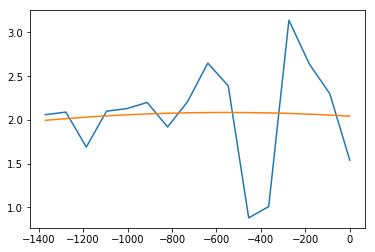

In [44]:
plt.plot(x,y)
plt.plot(x,yfit)
plt.show()

In [ ]:
print(p)
print(error)
print(res)
print((sales[2] - sales[1])/(days[2] - days[1]))
print((eps[2] - eps[1])/(days[2] - days[1]))
print((y[2] - y[0])/(x[2] - x[0]))